# Stock price prediction

Predict company closing stock price using LSTM model, based on the sotck price history.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf

## 1) Data preparation

Fetch stock price data for a given company (use-case Apple)

In [2]:
start_date = '2004-01-01'
end_date = date.today().strftime("%Y-%m-%d")
company_code = 'AAPL' #American Airlines

In [3]:
df = yf.download(tickers = company_code, start = start_date, end = end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,0.384821,0.388393,0.378214,0.380000,0.322118,144642400
2004-01-05,0.382500,0.399821,0.382500,0.395893,0.335590,395018400
2004-01-06,0.397321,0.400357,0.387679,0.394464,0.334379,509348000
2004-01-07,0.394643,0.407679,0.391607,0.403393,0.341948,586874400
2004-01-08,0.407857,0.423750,0.404464,0.417143,0.353604,460303200


Closing price history visualization

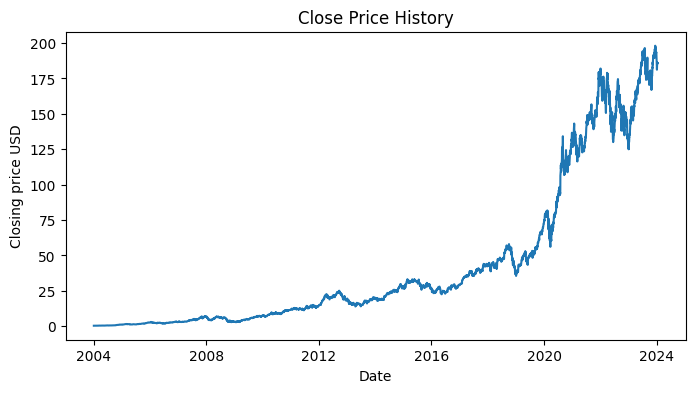

In [4]:
plt.figure(figsize=(8,4))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.show()

Split training / testing data

In [5]:
data = df['Close']
dataset = data.values #df to numpy array
len(dataset)

5042

In [6]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))
train_data = dataset[:training_data_len]
test_data = dataset[training_data_len:]

Normalize data

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_not_standardize = train_data
test_data_not_standardize = test_data 
train_data = scaler.fit_transform(train_data.reshape(-1,1)).reshape(-1)
test_data = scaler.fit_transform(test_data.reshape(-1,1)).reshape(-1)

In [8]:
# Used for visualization and test purposes
train_test_data_not_standardize = np.concatenate([train_data_not_standardize,test_data_not_standardize],axis=0)
standardized_train_test_data = np.concatenate([train_data,test_data],axis=0)

## 2) Next day closing stock price prediction

Predict closing stock price one day in advance using moving average

In [9]:
window_size = 100 # size of data window used to make predictions (nb of days)

### 2.1) Standard average

Use the arithmetic average of prices of the previous days to predict the price for the next day

In [10]:
# Predict prices on known values of previous days
standard_avg_preds = []
standard_avg_x = []
standard_avg_mse = []
for i in range(window_size, len(standardized_train_test_data)):
  prediction = np.mean( standardized_train_test_data[i-window_size:i] )
  standard_avg_preds.append(prediction)
  standard_avg_mse.append( (prediction - standardized_train_test_data[i])**2 )
  standard_avg_x.append(df.index[i])

print('MSE error for standard averaging: %.5f'%(np.mean(standard_avg_mse)))

MSE error for standard averaging: 0.00638


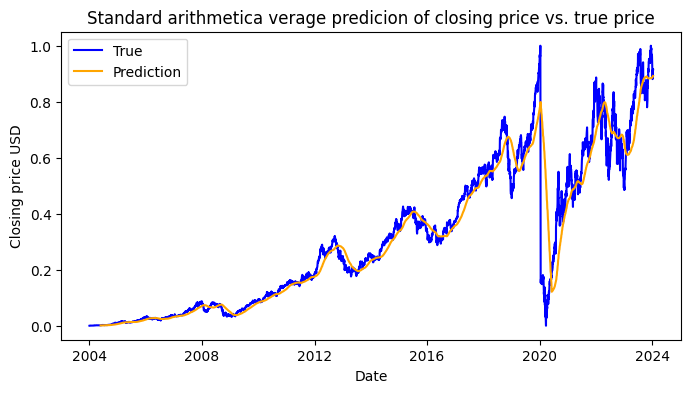

In [11]:
plt.figure(figsize = (8,4))
plt.plot(df.index, standardized_train_test_data, color='b', label='True')
plt.plot(standard_avg_x, standard_avg_preds, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title("Standard arithmetica verage predicion of closing price vs. true price")
plt.legend()
plt.show()

### 2.2) Exponential moving average

Using exponential moving average: $x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$, where:
- $EMA_0 = 0$
- $\gamma$ sets the contribution of the most recent prediction is to the EMA

In [12]:
run_avg_preds = []
run_avg_x = []
run_avg_mse = []
decay = 0.9
running_mean = 0.0
for i in range(1,len(standardized_train_test_data)):
    running_mean = running_mean*decay + (1.0-decay)*standardized_train_test_data[i-1]
    run_avg_preds.append(running_mean)
    run_avg_mse.append( (running_mean - standardized_train_test_data[i])**2 )
    run_avg_x.append(df.index[i])
print('MSE error for EMA averaging: %.5f'%(np.mean(run_avg_mse)))

MSE error for EMA averaging: 0.00109


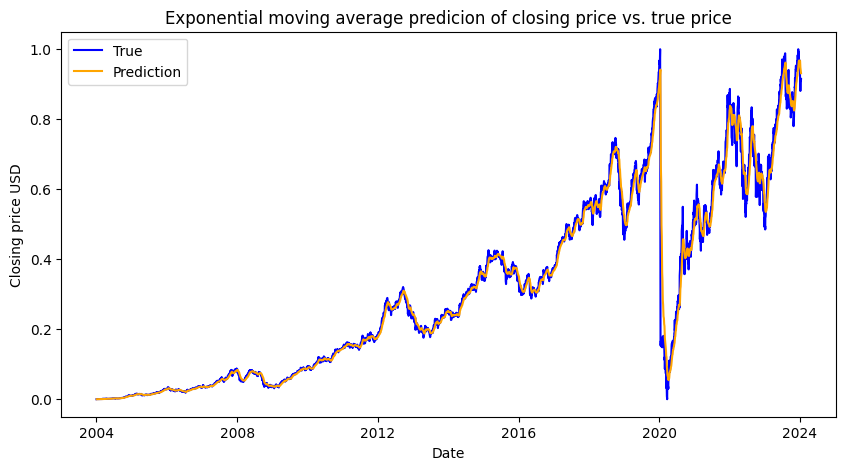

In [13]:
plt.figure(figsize = (10,5))
plt.plot(df.index, standardized_train_test_data, color='b', label='True')
plt.plot(run_avg_x, run_avg_preds, color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title("Exponential moving average predicion of closing price vs. true price")
plt.legend()
plt.show()

## 3) Next Prediction of future movements in closing stock prices (multiple day trends)

Function to convert a 1D time serie, into a datatset of data (size *look_back*) & targets (size *look_future*)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_future=1):
  dataX, dataY = [], []
  for i in range(look_back, len(dataset)-look_future-1):
    input = dataset[i-look_back:i]
    output = dataset[i:(i+look_future)]
    dataX.append(input)
    dataY.append(output)
  # reshape data to be [samples, time steps, features]
  dataX = np.array(dataX)
  dataX = np.reshape(dataX, (dataX.shape[0], dataX.shape[1], 1))
  return dataX, np.array(dataY)

Function to evaluate the predicions for each *look_future* days against target 

In [15]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	print(actual.shape[0], actual.shape[1])
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [16]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.3f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

Prepare data for predictions

In [165]:
# Prepare data
look_back = 7
look_future = 7

train_x, train_y = create_dataset(train_data, look_back, look_future)
test_x, test_y = create_dataset(test_data, look_back, look_future)

### 3.1) LSTM Model With Univariate Input and Vector Output

In [166]:
# Build model
verbose = 1
epochs = 70
batch_size = 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')

In [167]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 200)               161600    
                                                                 
 dense_29 (Dense)            (None, 100)               20100     
                                                                 
 dense_30 (Dense)            (None, 7)                 707       
                                                                 
Total params: 182,407
Trainable params: 182,407
Non-trainable params: 0
_________________________________________________________________


In [168]:
# Fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/70
252/252 [==============================] - 4s 5ms/step - loss: 0.0056
Epoch 2/70
252/252 [==============================] - 1s 5ms/step - loss: 2.1081e-04
Epoch 3/70
252/252 [==============================] - 2s 6ms/step - loss: 2.0810e-04
Epoch 4/70
252/252 [==============================] - 2s 9ms/step - loss: 1.8336e-04
Epoch 5/70
252/252 [==============================] - 3s 13ms/step - loss: 2.0544e-04
Epoch 6/70
252/252 [==============================] - 4s 14ms/step - loss: 1.8469e-04
Epoch 7/70
252/252 [==============================] - 3s 12ms/step - loss: 1.8301e-04
Epoch 8/70
252/252 [==============================] - 4s 16ms/step - loss: 1.8584e-04
Epoch 9/70
252/252 [==============================] - 3s 11ms/step - loss: 2.0028e-04
Epoch 10/70
252/252 [==============================] - 3s 12ms/step - loss: 1.7113e-04
Epoch 11/70
252/252 [==============================] - 3s 13ms/step - loss: 1.8081e-04
Epoch 12/70
252/252 [==============================] - 3s 12

In [169]:
test_predict = model.predict(test_x)

32/32 [==============================] - 1s 6ms/step


In [170]:
test_predict_denorm = scaler.inverse_transform(test_predict)
test_y_denorm = scaler.inverse_transform(test_y)
test_data_denorm = scaler.inverse_transform(test_data.reshape(-1,1)).reshape(-1)

In [171]:
score, scores = evaluate_forecasts(test_predict_denorm, test_y_denorm)
summarize_scores('lstm', score, scores)

993 7
lstm: [5.256] 2.736, 3.848, 4.650, 5.328, 5.792, 6.340, 6.881


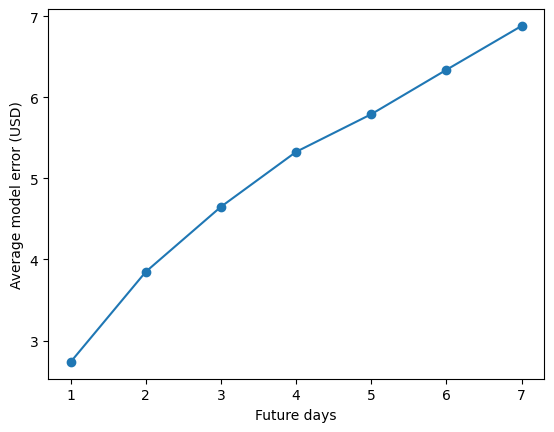

In [172]:
days = range(1, len(scores)+1)
plt.plot(days, scores, marker='o', label='lstm')
plt.xlabel("Future days")
plt.ylabel("Average model error (USD)")
plt.show()

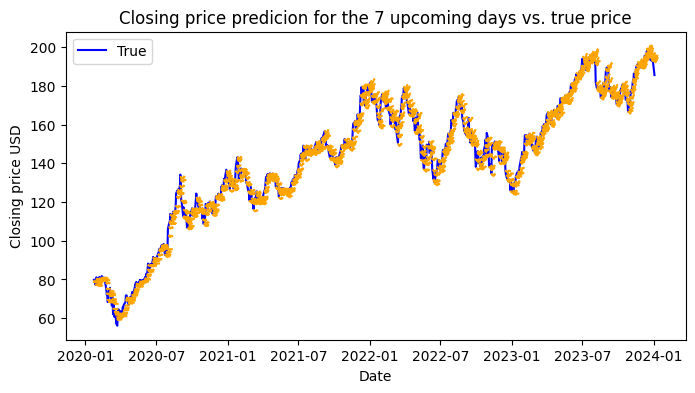

In [173]:
plt.figure(figsize = (8,4))
start = 0
end = min(test_predict_denorm.shape[0], 1000)
plt.plot(df.index[training_data_len + start+look_back: training_data_len + end+look_back], test_data_denorm[start+look_back:end+look_back], color='b', label='True')
for i, pred in enumerate(test_predict_denorm[start:end]):
  plt.plot(df.index[training_data_len+start+i+look_back: training_data_len+start+i+look_back+look_future], pred, color='orange')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title(f'Closing price predicion for the {look_future} upcoming day{"s" if (look_future > 1) else "s"} vs. true price')
plt.legend()
plt.show()

### 3.2) CNN-LSTM Encoder-Decoder Model With Univariate Input

In [174]:
# reshape output into [samples, timesteps, features]
train_y_3D = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

In [175]:
# define model
model_encod_decod = Sequential()
model_encod_decod.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model_encod_decod.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model_encod_decod.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model_encod_decod.add(tf.keras.layers.Flatten())
model_encod_decod.add(tf.keras.layers.RepeatVector(n_outputs))
model_encod_decod.add(LSTM(200, activation='relu', return_sequences=True))
model_encod_decod.add(tf.keras.layers.TimeDistributed(Dense(100, activation='relu')))
model_encod_decod.add(tf.keras.layers.TimeDistributed(Dense(1)))
model_encod_decod.compile(loss='mse', optimizer='adam')

In [176]:
# Fit network
verbose = 1
epochs = 20
batch_size = 16
model_encod_decod.fit(train_x, train_y_3D, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/20


252/252 [==============================] - 3s 5ms/step - loss: 0.0042
Epoch 2/20
252/252 [==============================] - 1s 6ms/step - loss: 2.5184e-04
Epoch 3/20
252/252 [==============================] - 2s 6ms/step - loss: 2.2809e-04
Epoch 4/20
252/252 [==============================] - 2s 6ms/step - loss: 2.9542e-04
Epoch 5/20
252/252 [==============================] - 2s 8ms/step - loss: 2.3514e-04
Epoch 6/20
252/252 [==============================] - 3s 10ms/step - loss: 2.6899e-04
Epoch 7/20
252/252 [==============================] - 2s 7ms/step - loss: 2.6006e-04
Epoch 8/20
252/252 [==============================] - 2s 9ms/step - loss: 2.2925e-04
Epoch 9/20
252/252 [==============================] - 2s 9ms/step - loss: 2.0602e-04
Epoch 10/20
252/252 [==============================] - 2s 8ms/step - loss: 2.2568e-04
Epoch 11/20
252/252 [==============================] - 2s 9ms/step - loss: 2.2390e-04
Epoch 12/20
252/252 [==============================] - 2s 8ms/step - loss: 2.

In [177]:
test_predict_encod_decod = model_encod_decod.predict(test_x)

32/32 [==============================] - 1s 8ms/step


In [178]:
test_predict_encod_decod = test_predict_encod_decod.reshape(test_predict_encod_decod.shape[0], test_predict_encod_decod.shape[1])
test_predict_encod_decod_denorm = scaler.inverse_transform(test_predict_encod_decod)

In [189]:
score, scores = evaluate_forecasts(test_predict_encod_decod_denorm, test_y_denorm)
summarize_scores('CNN-LSTM Encoder-Decoder', score, scores)

990 7
CNN-LSTM Encoder-Decoder: [4.629] 1.718, 2.653, 3.793, 4.609, 5.303, 5.900, 6.436


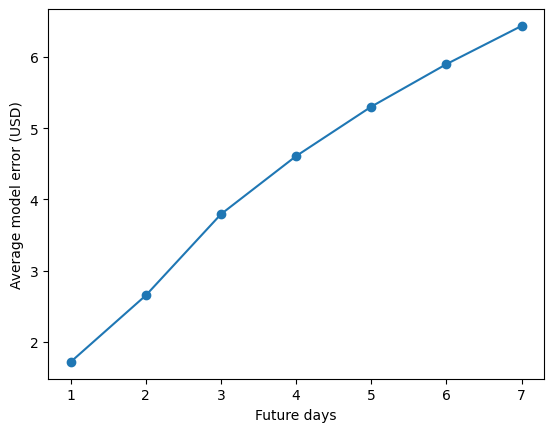

In [190]:
days = range(1, len(scores)+1)
plt.plot(days, scores, marker='o', label='lstm')
plt.xlabel("Future days")
plt.ylabel("Average model error (USD)")
plt.show()

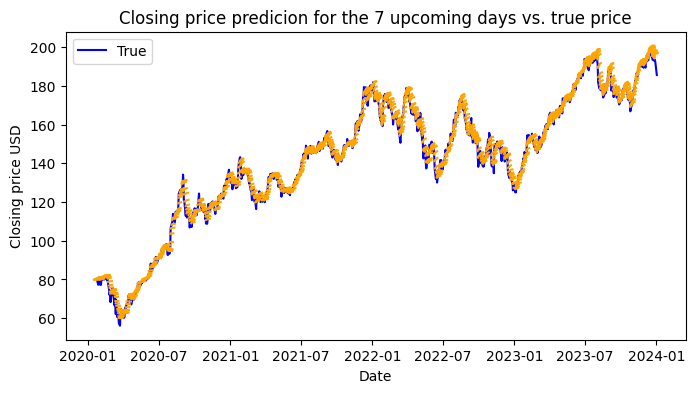

In [196]:
plt.figure(figsize = (8,4))
start = 0
end = min(test_predict_denorm.shape[0], 1000)
plt.plot(df.index[training_data_len + start+look_back: training_data_len + end+look_back], test_data_denorm[start+look_back:end+look_back], color='b', label='True')
for i, pred in enumerate(test_predict_encod_decod_denorm[start:end]):
  plt.plot(df.index[training_data_len+start+i+look_back: training_data_len+start+i+look_back+look_future], pred, color='orange')
plt.xlabel('Date')
plt.ylabel('Closing price USD')
plt.title(f'Closing price predicion for the {look_future} upcoming day{"s" if (look_future > 1) else "s"} vs. true price')
plt.legend()
plt.show()